In [1]:
import collections
import sys
import time

import numpy as np
import cv2
from IPython import display
import matplotlib.pyplot as plt
from openvino.runtime import Core

sys.path.append("../utils")
import notebook_utils as utils

from deepsort_utils.tracker import Tracker
from deepsort_utils.nn_matching import NearestNeighborDistanceMetric
from deepsort_utils.detection import Detection, compute_color_for_labels, xywh_to_xyxy, xywh_to_tlwh, tlwh_to_xyxy

In [2]:
from openvino.inference_engine import IECore

# Path to the .xml and .bin files of the IR model
model_xml = '../FP16/person-detection-0202.xml'
model_bin = '../FP16/person-detection-0202.bin'

# Create an Inference Engine core object
ie = IECore()

# Read the IR model
net = ie.read_network(model=model_xml, weights=model_bin)

# Load the network onto the available device
exec_net = ie.load_network(network=net, device_name='CPU')


In [3]:
ie_core = Core()

detection_model_path = "../FP16/person-detection-0202.xml"
reidentification_model_path="../FP16/person-reidentification-retail-0287/FP16/person-reidentification-retail-0287.xml"
class Model:
    """
    This class represents a OpenVINO model object.

    """
    def __init__(self, model_path, batchsize=1, device="AUTO"):
        """
        Initialize the model object
        
        Parameters
        ----------
        model_path: path of inference model
        batchsize: batch size of input data
        device: device used to run inference
        """
        self.model = ie_core.read_model(model=model_path)
        self.input_layer = self.model.input(0)
        self.input_shape = self.input_layer.shape
        self.height = self.input_shape[2]
        self.width = self.input_shape[3]

        for layer in self.model.inputs:
            input_shape = layer.partial_shape
            input_shape[0] = batchsize
            self.model.reshape({layer: input_shape})
        self.compiled_model = ie_core.compile_model(model=self.model, device_name=device)
        self.output_layer = self.compiled_model.output(0)

    def predict(self, input):
        """
        Run inference
        
        Parameters
        ----------
        input: array of input data
        """
        result = self.compiled_model(input)[self.output_layer]
        return result


detector = Model(detection_model_path)
# since the number of detection object is uncertain, the input batch size of reid model should be dynamic
extractor = Model(reidentification_model_path, -1)


In [4]:
def preprocess(frame, height, width):
    """
    Preprocess a single image
    
    Parameters
    ----------
    frame: input frame
    height: height of model input data
    width: width of model input data
    """
    resized_image = cv2.resize(frame, (width, height))
    resized_image = resized_image.transpose((2, 0, 1))
    input_image = np.expand_dims(resized_image, axis=0).astype(np.float32)
    return input_image


def batch_preprocess(img_crops, height, width):
    """
    Preprocess batched images
    
    Parameters
    ----------
    img_crops: batched input images
    height: height of model input data
    width: width of model input data
    """
    img_batch = np.concatenate([
        preprocess(img, height, width)
        for img in img_crops
    ], axis=0)
    return img_batch


def process_results(h, w, results, thresh=0.5):
    """
    postprocess detection results
    
    Parameters
    ----------
    h, w: original height and width of input image
    results: raw detection network output
    thresh: threshold for low confidence filtering
    """
    # The 'results' variable is a [1, 1, N, 7] tensor.
    detections = results.reshape(-1, 7)
    boxes = []
    labels = []
    scores = []
    for i, detection in enumerate(detections):
        _, label, score, xmin, ymin, xmax, ymax = detection
        # Filter detected objects.
        if score > thresh:
            # Create a box with pixels coordinates from the box with normalized coordinates [0,1].
            boxes.append(
                [(xmin + xmax) / 2 * w, (ymin + ymax) / 2 * h, (xmax - xmin) * w, (ymax - ymin) * h]
            )
            labels.append(int(label))
            scores.append(float(score))

    if len(boxes) == 0:
        boxes = np.array([]).reshape(0, 4)
        scores = np.array([])
        labels = np.array([])
    return np.array(boxes), np.array(scores), np.array(labels)


def draw_boxes(img, bbox, identities=None):
    """
    Draw bounding box in original image
    
    Parameters
    ----------
    img: original image
    bbox: coordinate of bounding box
    identities: identities IDs
    """
    for i, box in enumerate(bbox):
        x1, y1, x2, y2 = [int(i) for i in box]
        # box text and bar
        id = int(identities[i]) if identities is not None else 0
        color = compute_color_for_labels(id)
        label = '{}{:d}'.format("", id)
        t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 2, 2)[0]
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 3)
        cv2.rectangle(
            img, (x1, y1), (x1 + t_size[0] + 3, y1 + t_size[1] + 4), color, -1)
        cv2.putText(
            img,
            label,
            (x1, y1 + t_size[1] + 4),
            cv2.FONT_HERSHEY_PLAIN,
            2,
            [255, 255, 255],
            2
        )
    return img


def cosin_metric(x1, x2):
    """
    Calculate the consin distance of two vector
    
    Parameters
    ----------
    x1, x2: input vectors
    """
    return np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))

In [5]:

MIN_DISTANCE = 100

def calculate_distance(point1, point2):
    return np.linalg.norm(point1 - point2)


def run_social_distancing(source=0, flip=False, use_popup=False, skip_first_frames=0):
    player = None
    try:
        player = utils.VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()
        while True:
            frame = player.next()
            if frame is None:
                print("Source ended")
                break

            h, w = frame.shape[:2]
            input_image = preprocess(frame, detector.height, detector.width)

            start_time = time.time()
            output = detector.predict(input_image)
            stop_time = time.time()
            processing_times.append(stop_time - start_time)
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time

            bbox_xywh, scores, label = process_results(h, w, results=output)

            violations = set()
            for i, (box, score) in enumerate(zip(bbox_xywh, scores)):
                x1, y1, x2, y2 = xywh_to_xyxy(box, h, w)
                person1_center = np.array([(x1 + x2) / 2, (y1 + y2) / 2])
                for j, (other_box, other_score) in enumerate(zip(bbox_xywh[i+1:], scores[i+1:])):
                    other_x1, other_y1, other_x2, other_y2 = xywh_to_xyxy(other_box, h, w)
                    person2_center = np.array([(other_x1 + other_x2) / 2, (other_y1 + other_y2) / 2])
                    distance = calculate_distance(person1_center, person2_center)
                    if distance < MIN_DISTANCE:
                        violations.add(i)
                        violations.add(i + j + 1)

            for i, (box, score) in enumerate(zip(bbox_xywh, scores)):
                x1, y1, x2, y2 = xywh_to_xyxy(box, h, w)
                color = (0, 255, 0)  # default color: green

                if i in violations:
                    color = (0, 0, 255)  # color: red

                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0,0,255),
                thickness=5,
                lineType=cv2.LINE_AA,
            )

            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                if key == 27:
                    break
            else:
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                i = display.Image(data=encoded_img)
                display.clear_output(wait=True)
                display.display(i)

    except KeyboardInterrupt:
        print("Interrupted")
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()




In [6]:
NN_BUDGET = 100
MAX_COSINE_DISTANCE = 0.6  # threshold of matching object
metric = NearestNeighborDistanceMetric(
    "cosine", MAX_COSINE_DISTANCE, NN_BUDGET
)
tracker = Tracker(
    metric,
    max_iou_distance=0.7,
    max_age=70,
    n_init=3
)

In [7]:
run_social_distancing(source=1, flip=True, use_popup=False)

Cannot open camera 1


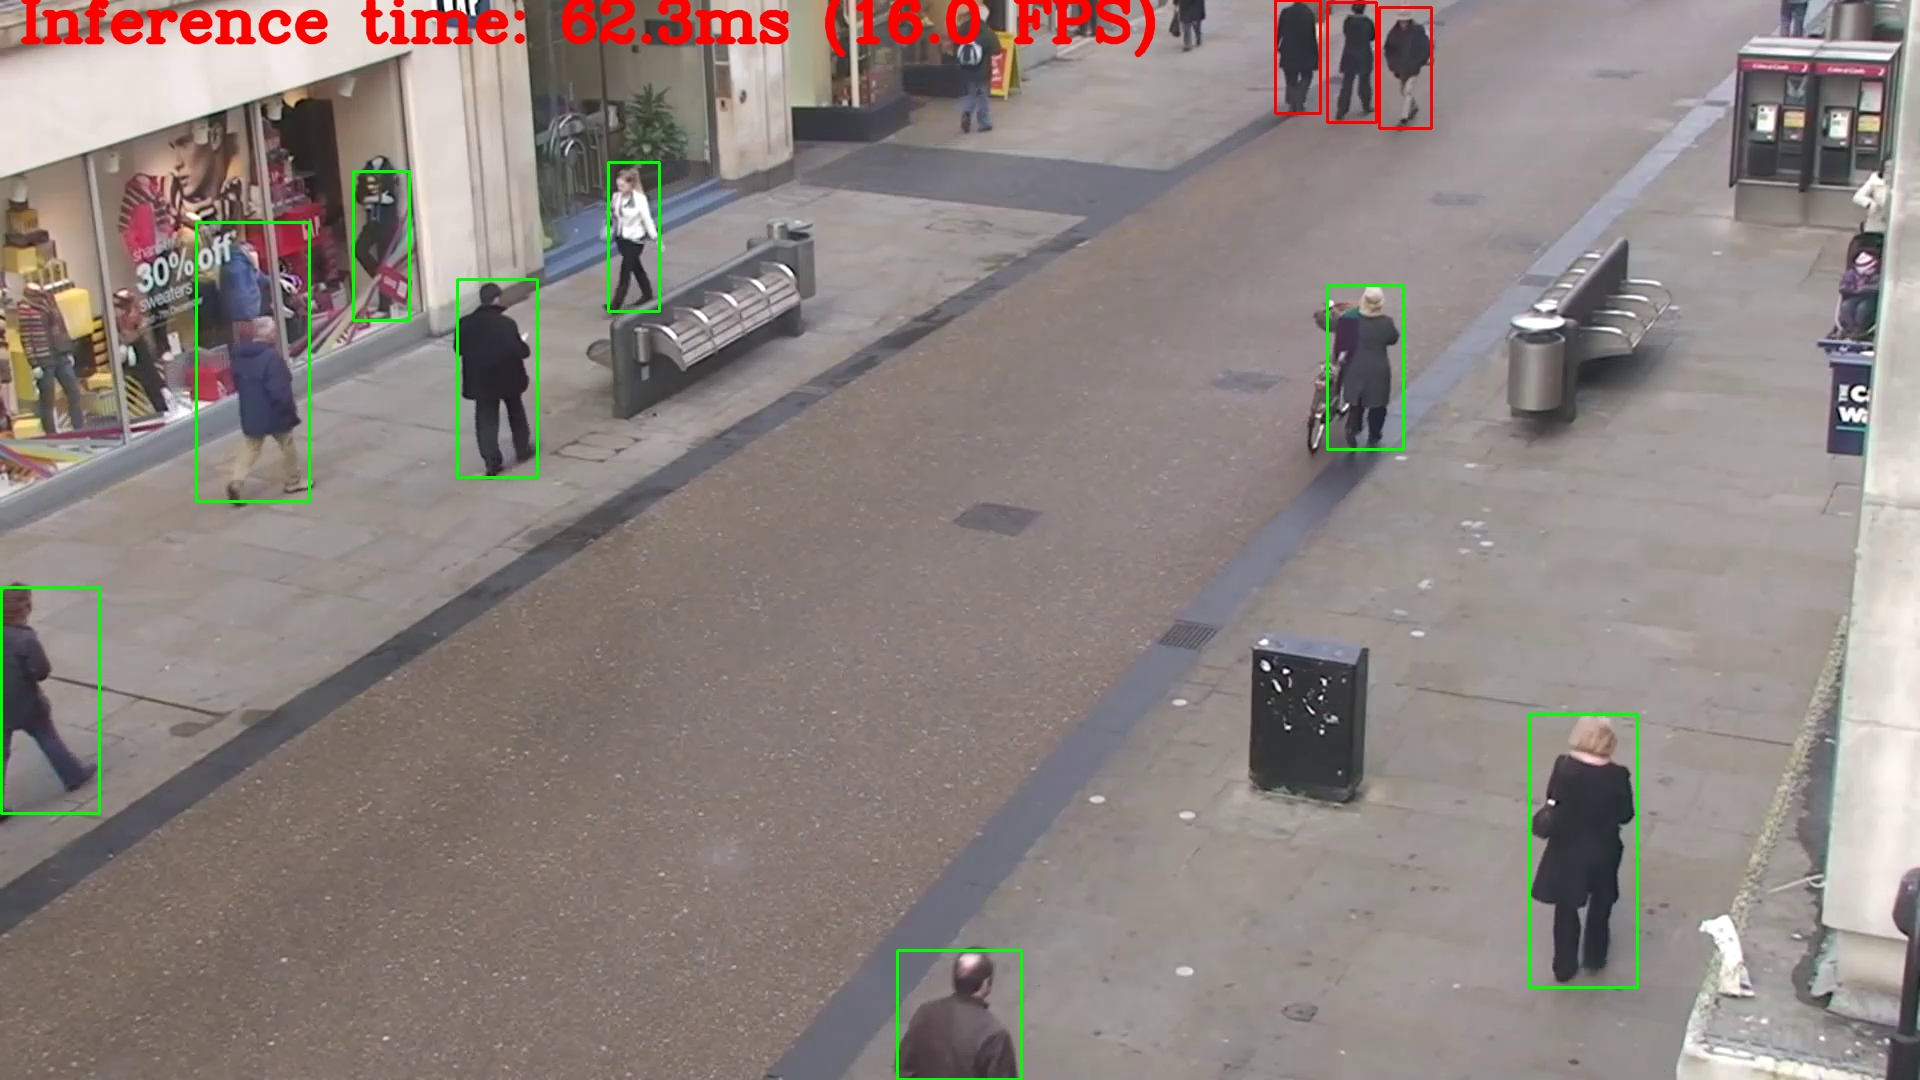

Source ended


In [8]:
video_file = "../data/video/people.mp4"
run_social_distancing(source=video_file, flip=False, use_popup=False)

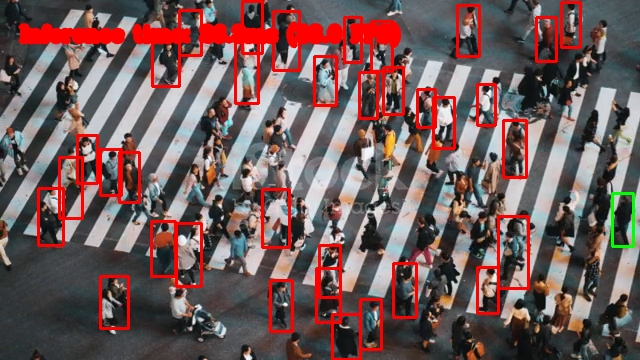

Source ended


In [9]:
video_file = "../data/video/istockphoto.mp4"
run_social_distancing(source=video_file, flip=False, use_popup=False)

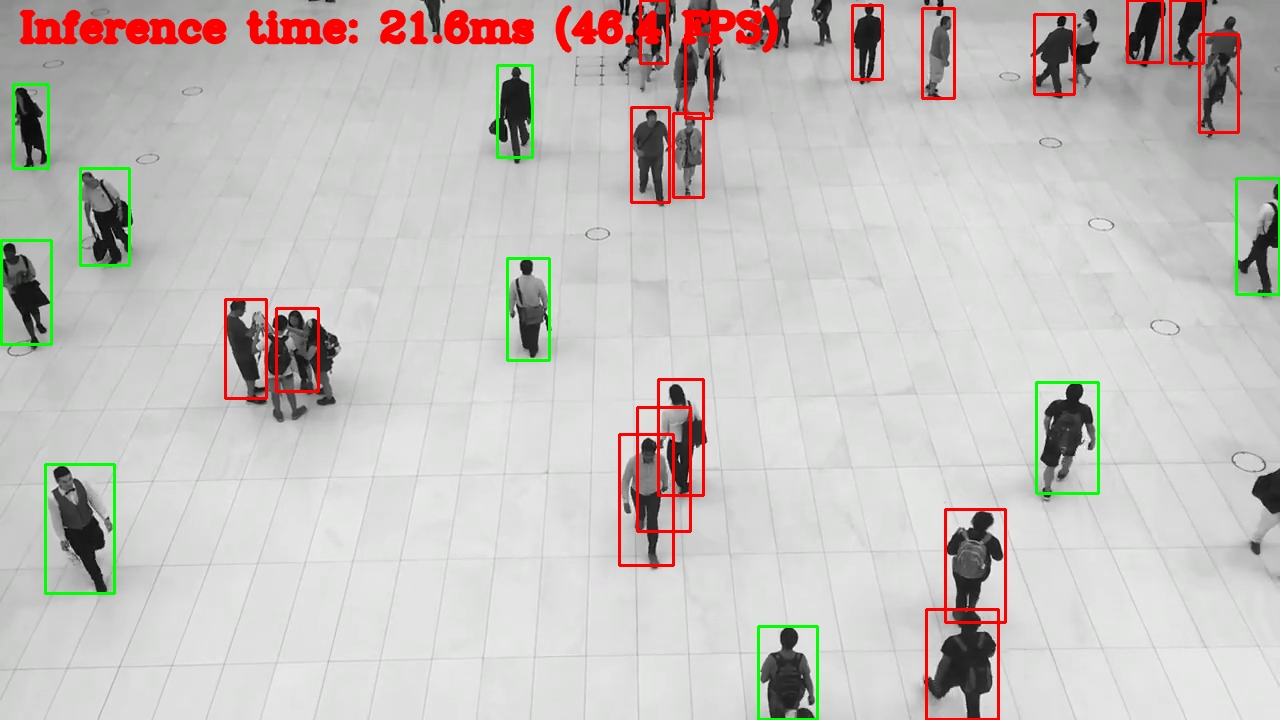

Source ended


In [13]:
video_file = "../data/video/People Passing By.mp4"
run_social_distancing(source=video_file, flip=False, use_popup=False)

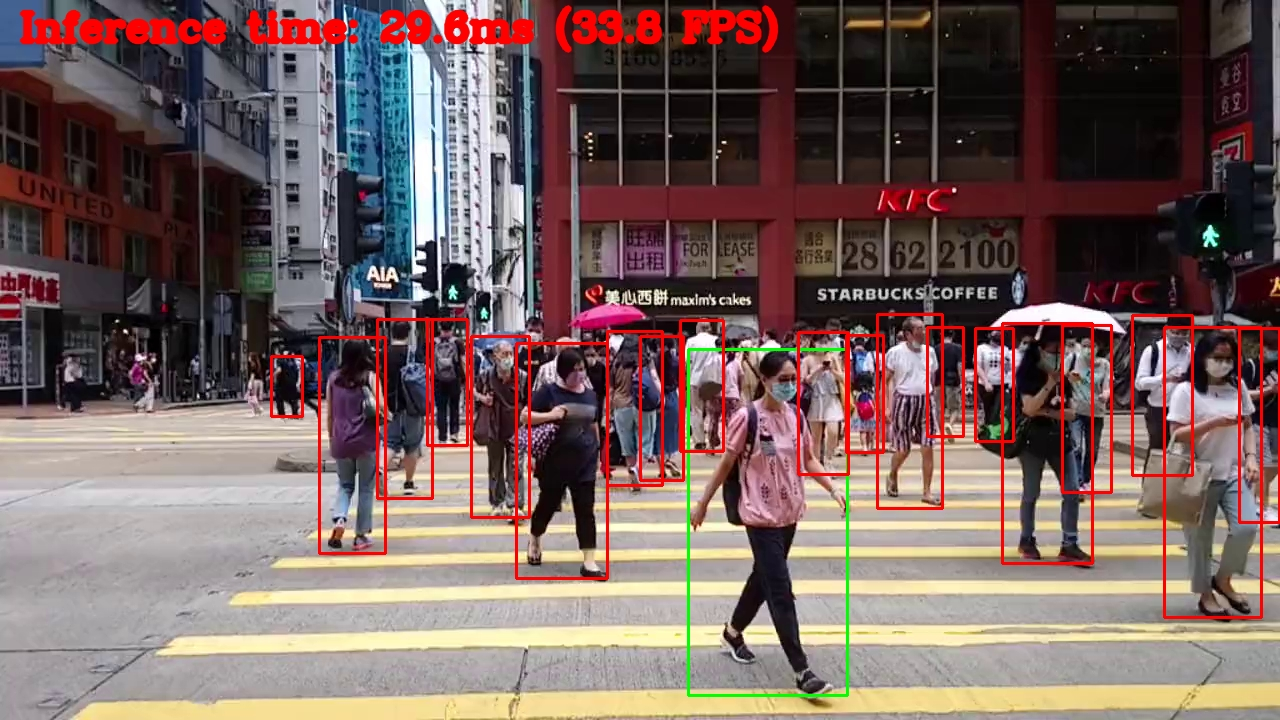

Source ended


In [11]:
video_file = "../data/video/pexels-suika.mp4"
run_social_distancing(source=video_file, flip=False, use_popup=False)

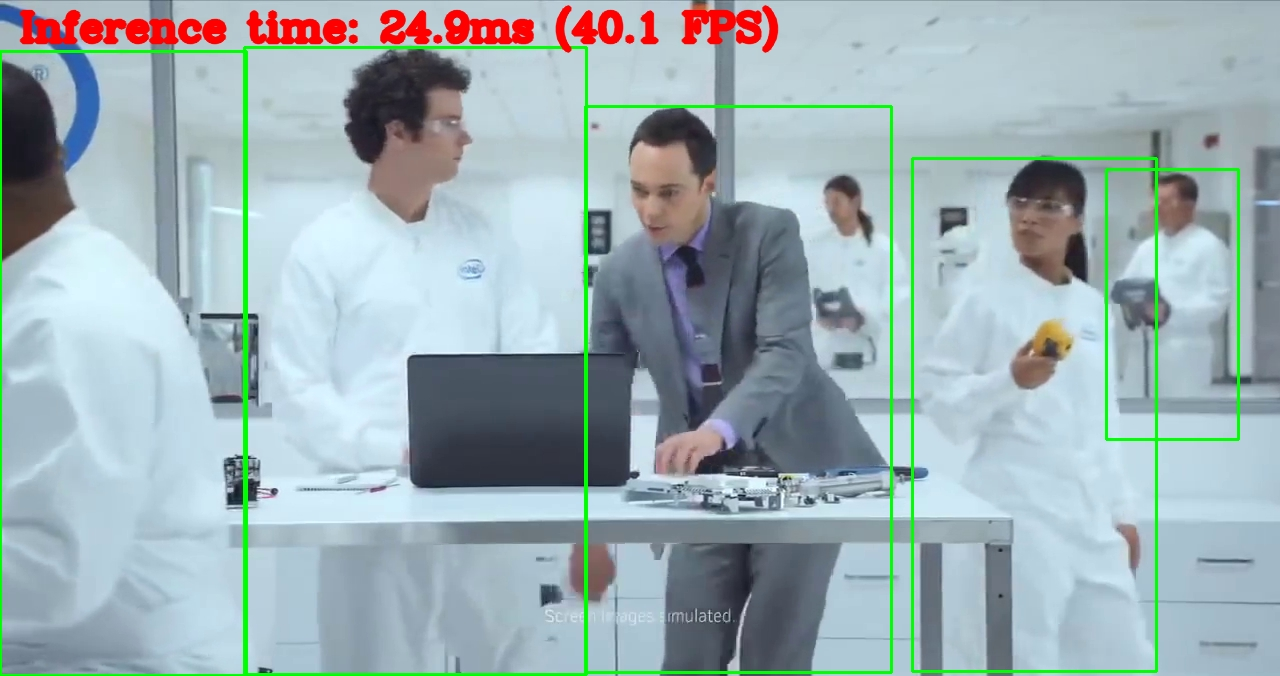

Interrupted


In [12]:
video_file = "../data/video/Sheldon Cooper Jim Parsons at Intels Lab.mp4"
run_social_distancing(source=video_file, flip=False, use_popup=False)